In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tabulate import tabulate


In [2]:
#Set parameters
max_val = 1
min_val = -0.2
rest_val = -0.1
decay_val = 0.1
estr_val = 0.4
alpha_val = 0.1
# alpha_val = 0.1
gamma_val = 0.1

#Set number of cycles
ncycles = 100

In [3]:
def pool(n, name, type, nunits, unit_names, projections, weights, extInput=None):
    """
    n: pool number (numeric)
    name: name of pool (e.g., 'hidden') (string)
    type: type of pool (e.g., 'input') (string)
    nunits: number of units in pool (numeric)
    projections: list of pools (list)
    weights: list of weight matrices indexed by pool (list)
    extInput: external input to pool (optional, defaults to None)
    """
    if extInput is None:
        extInput = np.zeros((1, nunits))

    return {"pool_number": n,
        "name": name,
        "type": type, # hidden or input
        "nunits": nunits,
        "unit_names": unit_names,
        "projections": projections,
        "weights": weights,
        "extInput": extInput,
        "activation": np.zeros((1, nunits)),
        "inhibition": np.zeros((1, nunits)),
        "excitation": np.zeros((1, nunits)),
        "netInput": np.zeros((1, nunits)),
        "activation_history": []}


In [4]:
def set_extInput(pool_i, input):
    
    pool_i["extInput"] = np.array([input])
    
    return pool_i

In [5]:
# import data
# Features to Features [14 x 14]
f2F = pd.read_csv("csv_files/NBA_features2features_Large.csv")


f2F.index = f2F.iloc[:, 0]
f2F = f2F.iloc[:, 1:]
f2F_df = f2F.copy()
f2F = np.array(f2F)

features_tuple = tuple(str(idx) for idx in f2F_df.index)

num_features = len(features_tuple)

In [6]:
num_features

50

In [21]:
features_tuple

('Forward',
 'Center',
 'Guard',
 'Under 6',
 '6 - 6_5',
 '6_5 - 6_11',
 '7 and Over',
 '18-24',
 '25-29',
 '30-34',
 '35+',
 'Round 1',
 'Round 2',
 'Undrafted',
 'Domestic',
 'International',
 'Eastern',
 'Western',
 'All_Star_Yes',
 'All_Star_No',
 'Atlanta Hawks',
 'Boston Celtics',
 'Brooklyn Nets',
 'Charlotte Hornets',
 'Chicago Bulls',
 'Cleveland Cavaliers',
 'Dallas Mavericks',
 'Denver Nuggets',
 'Detroit Pistons',
 'Golden State Warriors',
 'Houston Rockets',
 'Indiana Pacers',
 'Los Angeles Clippers',
 'Los Angeles Lakers',
 'Memphis Grizzlies',
 'Miami Heat',
 'Milwaukee Bucks',
 'Minnesota Timberwolves',
 'New Orleans Pelicans',
 'New York Knicks',
 'Oklahoma City Thunder',
 'Orlando Magic',
 'Philadelphia Sixers',
 'Phoenix Suns',
 'Portland Trail Blazers',
 'Sacramento Kings',
 'San Antonio Spurs',
 'Toronto Raptors',
 'Utah Jazz',
 'Washington Wizards')

In [7]:
# features to hidden matrix
f2H = pd.read_csv("csv_files/NBA_features2Hidden_Large.csv", index_col=0)
f2H_df = f2H.copy()
f2H = f2H.fillna(0)
f2H = f2H.to_numpy()

names_tuple = tuple(str(idx) for idx in f2H_df.index)

num_players = len(names_tuple)

In [8]:
num_players

509

In [9]:
def run_simulation(pool_, ncycles):

    for x in range(ncycles):
        print('cycle x:',x)
        for i in range(len(pool_)):
            
            #print('pool i:',i)
            pool_[i]['excitation'] = np.zeros((1, pool_[i]['nunits']))
            pool_[i]['inhibition'] = np.zeros((1, pool_[i]['nunits']))

            for sender in pool_[i]['projections']:
                #print("sender idx:",sender)
                positive_acts_indices = np.argwhere(pool_[sender]['activation'] > 0)[:,1] #np.where(pool_[sender]['activation'] > 0)[0]

                #print("positive activation idx:", positive_acts_indices)

                if len(positive_acts_indices) > 0:
                    for k in range(len(positive_acts_indices)):
                        
                        index = positive_acts_indices[k]
                        #print('specific index:',index)
                        wts = pool_[i]['weights'][sender][index, :]
                        #print('wts = pool_[i][weights][sender][index, :]', wts)
                        #pool_[i]['excitation'][wts > 0] += pool_[sender]['activation'][index] * wts[wts > 0]
                        #pool_[i]['inhibition'][wts < 0] += pool_[sender]['activation'][index] * wts[wts < 0]

                        wts_e=np.argwhere([wts > 0])[:,1]
                        wts_i=np.argwhere([wts < 0])[:,1]

                        #print('wts>0, wts<0',wts_e,wts_i)

                        #print('before:',pool_[i]['excitation'],pool_[i]['inhibition'])

                        for w_e in wts_e: 
                            pool_[i]['excitation'][:,w_e] += pool_[sender]['activation'][:,index] * wts[w_e]                           
                        for w_i in wts_i:
                            pool_[i]['inhibition'][:,w_i] += pool_[sender]['activation'][:,index] * wts[w_i]
                        
                        #print('after:',pool_[i]['excitation'],pool_[i]['inhibition'])
                            

            pool_[i]['excitation'] *= alpha_val
            pool_[i]['inhibition'] *= gamma_val
            #print('after after:',pool_[i]['excitation'],pool_[i]['inhibition'])
            pool_[i]['netInput'] = pool_[i]['excitation'] + pool_[i]['inhibition'] + estr_val * pool_[i]['extInput']

            #print('netinput: ',pool_[i]['netInput'])
        
        for i in range(len(pool_)):

            #print(i)
            pns = np.argwhere(pool_[i]['netInput'] > 0)[:,1]#np.where(pool_[i]['netInput'] > 0)[0]

            if len(pns) > 0:
                for p in pns:
                    pool_[i]['activation'][:,p] += (max_val - pool_[i]['activation'][:,p]) * pool_[i]['netInput'][:,p] - decay_val * (pool_[i]['activation'][:,p] - rest_val)

            nps = np.argwhere(pool_[i]['netInput'] <= 0)[:,1]

            if len(nps) > 0:
                for n in nps:
                    pool_[i]['activation'][:,n] += (pool_[i]['activation'][:,n] - min_val) * pool_[i]['netInput'][:,n] - decay_val * (pool_[i]['activation'][:,n] - rest_val)
            
            pool_[i]['activation'][pool_[i]['activation'] > max_val] = max_val
            pool_[i]['activation'][pool_[i]['activation'] < min_val] = min_val

            pool_[i]['activation_history'].append(np.copy(pool_[i]['activation']))
    
    return pool_

In [10]:
def plot_pools(pool_):

    # pool 1 features
    #a_history_1 = pool_[0]['activation_history']
    a_history_1=np.reshape(np.array(pool_[0]['activation_history']), [ncycles, num_features])
    unit_names_1 = pool_[0]['unit_names']
    m1 = pd.DataFrame(a_history_1)
    m1.columns = unit_names_1
    m1['step']=m1.index
    dfm1=m1.melt('step',var_name='Feature', value_name='Activation')
    plot1=sns.catplot(x="step", y="Activation", hue='Feature', data=dfm1,  kind='point')
    plt.title('Activation of Feature Units by Cycle')
    plt.xlabel('Cycle')
    plt.ylabel('Activation')

    # pool 2 names
    a_history_2 = np.reshape(np.array(pool_[1]['activation_history']), [ncycles, num_players])
    unit_names_2 = pool_[1]['unit_names']
    m2 = pd.DataFrame(a_history_2)
    m2.columns = unit_names_2
    m2['step']=m2.index
    dfm2=m2.melt('step',var_name='Name', value_name='Activation')
    plot2=sns.catplot(x="step", y="Activation", hue='Name', data=dfm2,  kind='point')
    plt.title('Activation of Name Units by Cycle')
    plt.xlabel('Cycle')
    plt.ylabel('Activation')

    # pool 3 - hidden 
    a_history = np.reshape(np.array(pool_[2]['activation_history']), [ncycles, num_players])
    unit_names = pool_[2]['unit_names']
    m3 = pd.DataFrame(a_history)
    m3.columns = unit_names
    m3['step']=m3.index
    dfm3=m3.melt('step',var_name='Hidden Unit', value_name='Activation')
    plot3=sns.catplot(x="step", y="Activation", hue='Hidden Unit', data=dfm3,  kind='point')
    plt.title('Activation of Hidden Units by Cycle')
    plt.xlabel('Cycle')
    plt.ylabel('Activation')

    return {"features": plot1, "names": plot2, "hidden": plot3}


In [11]:
def rank_activations_by_pool(pool_):
    
    features_out = pool_[0]['activation'].flatten()
    features_names = pool_[0]['unit_names']
    features_df = pd.DataFrame({'feature': features_names, 'activation': features_out})
    features_df = features_df.sort_values(by=['activation'], ascending=False)
    
    names_out = pool_[1]['activation'].flatten()
    names_names = pool_[1]['unit_names']
    names_df = pd.DataFrame({'name': names_names, 'activation': names_out})
    names_df = names_df.sort_values(by=['activation'], ascending=False)
    
    hidden_out = pool_[2]['activation'].flatten()
    hidden_names = pool_[2]['unit_names']
    hidden_df = pd.DataFrame({'name': hidden_names, 'activation': hidden_out})
    hidden_df = hidden_df.sort_values(by=['activation'], ascending=False)
    
    return {'features': features_df, 'names': names_df, 'hidden': hidden_df}


In [12]:
# # Features to Features [14 x 14]
# f2F = pd.read_csv("csv_files/NBA_features2features_Small.csv")


# f2F.index = f2F.iloc[:, 0]
# f2F = f2F.iloc[:, 1:]
# f2F_df = f2F.copy()
# f2F = np.array(f2F)

# features_tuple = tuple(str(idx) for idx in f2F_df.index)

# num_features = len(features_tuple)

In [13]:
# # features to hidden matrix
# f2H = pd.read_csv("csv_files/NBA_features2Hidden_Small.csv", index_col=0)
# f2H_df = f2H.copy()
# f2H = f2H.fillna(0)
# f2H = f2H.to_numpy()

# names_tuple = tuple(str(idx) for idx in f2H_df.index)

# num_players = len(names_tuple)


In [14]:
# names to names

n2N = np.full((num_players, num_players), -1)
np.fill_diagonal(n2N, 0)
#n2N

In [15]:
# names to hidden [27 x 27]
# [1] Art Al Sam Clyde Mike Jim Greg John Doug Lance George Pete 
# [13] Fred Gene Ralph Phil Ike Nick Don Ned Karl Ken Earl Rick Ol Neal Dave
n2H = np.eye(num_players)
#n2H

In [16]:
h2H = n2N

In [17]:
featurePool=pool(0, "features", "input", num_features, unit_names = list(features_tuple),projections = list((0,2)), weights = {0 : f2F,2 : f2H})


In [18]:
namePool=pool(1, "names", "input", num_players, unit_names = list(names_tuple),projections = list((1,2)), weights = {1 : n2N,2 : n2H})

In [19]:
hiddenPool=pool(2, "hidden", "hidden", num_players, unit_names = list(names_tuple),projections = list((0,1,2)), weights = {0:f2H.T, 1:n2H.T, 2:h2H})

In [20]:
# js = pd.read_csv('jetsSharks.csv', header=None)
# js = pd.read_csv('nba_players_small.csv', header=None)
js = pd.read_csv('csv_files/nba_players_large.csv')
# js.columns = ["Name", "Affiliation", "Age", "Education", "Relationship Status", "Occupation"]
print(tabulate(js, headers='keys', tablefmt='psql'))

+-----+--------------------------+------------+--------------+-------+-----------+---------------+--------------+--------------+------------------------+
|     | Name                     | Position   | Height       | Age   | Draft     | Nationality   | Conference   | All_Star     | Team                   |
|-----+--------------------------+------------+--------------+-------+-----------+---------------+--------------+--------------+------------------------|
|   0 | Precious Achiuwa         | Forward    | 6'5" - 6'11" | 18-24 | Round 1   | International | Eastern      | All_Star_No  | Toronto Raptors        |
|   1 | Steven Adams             | Center     | 6'5" - 6'11" | 25-29 | Round 1   | International | Western      | All_Star_No  | Memphis Grizzlies      |
|   2 | Bam Adebayo              | Center     | 6'5" - 6'11" | 25-29 | Round 1   | Domestic      | Eastern      | All_Star_Yes | Miami Heat             |
|   3 | Ochai Agbaji             | Forward    | 6' - 6'5"    | 18-24 | Round

In [22]:
# featurePool=set_extInput(featurePool, np.array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]))

# Guard, 6_5 to 6_11
featurePool=set_extInput(featurePool, np.array([0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))

namePool=set_extInput(namePool, np.zeros(num_players))

In [23]:
pool_= list((featurePool, namePool, hiddenPool))
#pool_[0]

In [24]:

pool_=run_simulation(pool_,ncycles)

cycle x: 0
cycle x: 1
cycle x: 2
cycle x: 3
cycle x: 4
cycle x: 5
cycle x: 6
cycle x: 7
cycle x: 8
cycle x: 9
cycle x: 10
cycle x: 11
cycle x: 12
cycle x: 13
cycle x: 14
cycle x: 15
cycle x: 16
cycle x: 17
cycle x: 18
cycle x: 19
cycle x: 20
cycle x: 21
cycle x: 22
cycle x: 23
cycle x: 24
cycle x: 25
cycle x: 26
cycle x: 27
cycle x: 28
cycle x: 29
cycle x: 30
cycle x: 31
cycle x: 32
cycle x: 33
cycle x: 34
cycle x: 35
cycle x: 36
cycle x: 37
cycle x: 38
cycle x: 39
cycle x: 40
cycle x: 41
cycle x: 42
cycle x: 43
cycle x: 44
cycle x: 45
cycle x: 46
cycle x: 47
cycle x: 48
cycle x: 49
cycle x: 50
cycle x: 51
cycle x: 52
cycle x: 53
cycle x: 54
cycle x: 55
cycle x: 56
cycle x: 57
cycle x: 58
cycle x: 59
cycle x: 60
cycle x: 61
cycle x: 62
cycle x: 63
cycle x: 64
cycle x: 65
cycle x: 66
cycle x: 67
cycle x: 68
cycle x: 69
cycle x: 70
cycle x: 71
cycle x: 72
cycle x: 73
cycle x: 74
cycle x: 75
cycle x: 76
cycle x: 77
cycle x: 78
cycle x: 79
cycle x: 80
cycle x: 81
cycle x: 82
cycle x: 83
cy

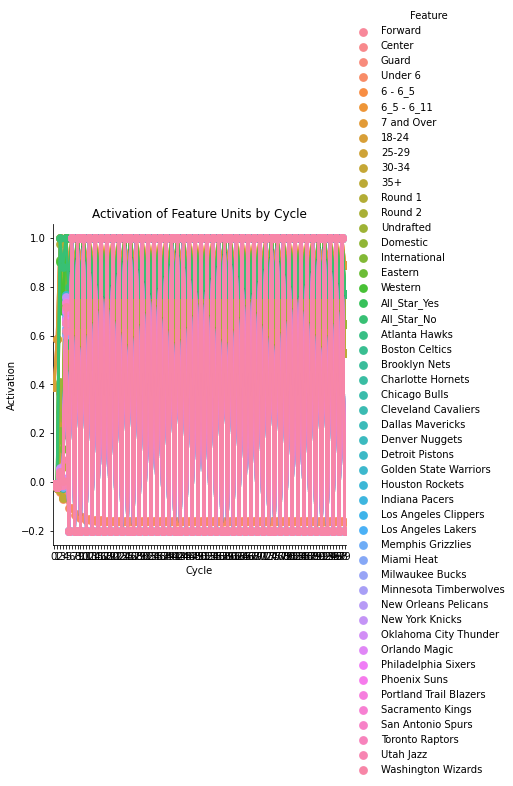

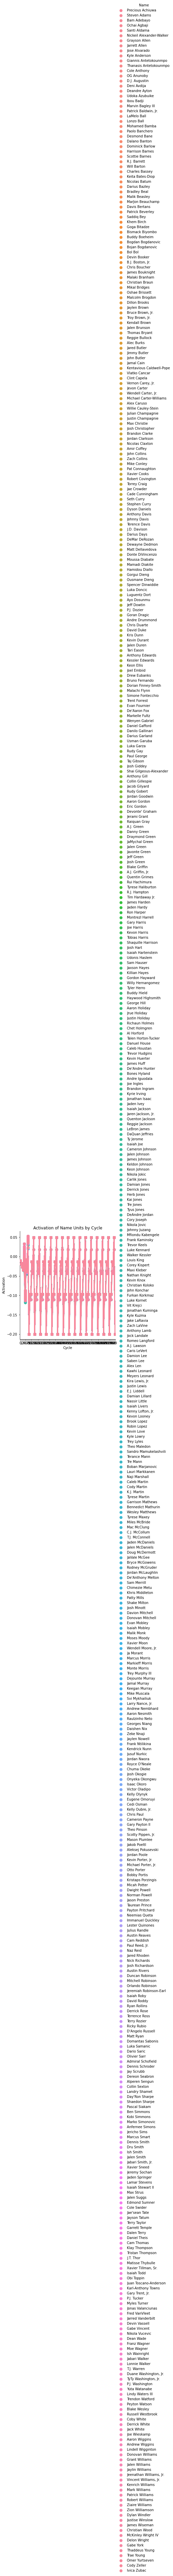

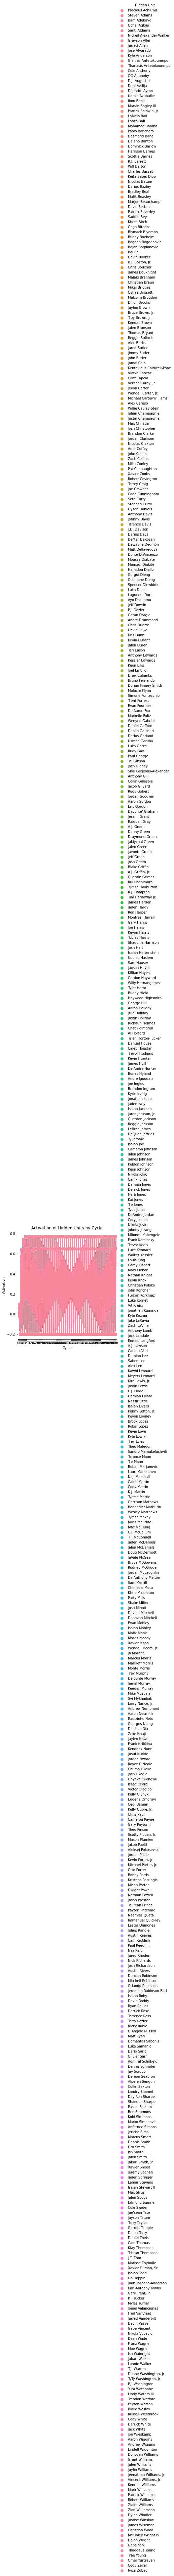

In [25]:
nnplot = plot_pools(pool_)
#nnplot.hidden

In [26]:
ranked_activations = rank_activations_by_pool(pool_)

# Display the 'hidden' pool in a table
hidden_table = ranked_activations['hidden']
hidden_table = hidden_table.reset_index(drop=True)  # Reset index to start from 0
hidden_table.insert(0, 'Rank', range(1, len(hidden_table) + 1))  # Add rank column
hidden_table_html = tabulate(hidden_table, headers='keys')  # Convert to HTML table

# Print the HTML table
print(hidden_table_html)

       Rank  name                        activation
---  ------  ------------------------  ------------
  0       1  Precious Achiuwa              0.775897
  1       2  Mike Muscala                  0.775897
  2       3  Jordan Nwora                  0.775897
  3       4  Jusuf Nurkic                  0.775897
  4       5  Kendrick Nunn                 0.775897
  5       6  Frank Ntilikina               0.775897
  6       7  Jaylen Nowell                 0.775897
  7       8  Zeke Nnaji                    0.775897
  8       9  Daishen Nix                   0.775897
  9      10  Georges Niang                 0.775897
 10      11  Raulzinho Neto                0.775897
 11      12  Aaron Nesmith                 0.775897
 12      13  Andrew Nembhard               0.775897
 13      14  Larry Nance, Jr.              0.775897
 14      15  Svi Mykhailiuk                0.775897
 15      16  Keegan Murray                 0.775897
 16      17  Chuma Okeke                   0.775897
 17      18 

In [33]:
names_table = ranked_activations['names']
names_table = names_table.reset_index(drop=True)  # Reset index to start from 0
names_table.insert(0, 'Rank', range(1, len(names_table) + 1))  # Add rank column
names_table_html = tabulate(names_table, headers='keys')  # Convert to HTML table

# Print the HTML table
print(names_table_html)

# ranked_activations

       Rank  name                        activation
---  ------  ------------------------  ------------
  0       1  Precious Achiuwa                  -0.2
  1       2  Svi Mykhailiuk                    -0.2
  2       3  Royce O'Neale                     -0.2
  3       4  Jordan Nwora                      -0.2
  4       5  Jusuf Nurkic                      -0.2
  5       6  Kendrick Nunn                     -0.2
  6       7  Frank Ntilikina                   -0.2
  7       8  Jaylen Nowell                     -0.2
  8       9  Zeke Nnaji                        -0.2
  9      10  Daishen Nix                       -0.2
 10      11  Georges Niang                     -0.2
 11      12  Raulzinho Neto                    -0.2
 12      13  Aaron Nesmith                     -0.2
 13      14  Andrew Nembhard                   -0.2
 14      15  Larry Nance, Jr.                  -0.2
 15      16  Mike Muscala                      -0.2
 16      17  Josh Okogie                       -0.2
 17      18 

In [27]:
# Display the 'hidden' pool in a table
feature_table = ranked_activations['features']
#feature_table = feature_table.reset_index(drop=True)  # Reset index to start from 0
#feature_table.insert(0, 'Rank', range(1, len(feature_table) + 1))  # Add rank column
#feature_table_html = tabulate(feature_table, headers='keys')  # Convert to HTML table

#Print feature table
print(feature_table)

                   feature  activation
2                    Guard    0.890000
4                  6 - 6_5    0.890000
7                    18-24    0.890000
17                 Western    0.770000
19             All_Star_No    0.770000
18            All_Star_Yes    0.770000
16                 Eastern    0.770000
15           International    0.770000
14                Domestic    0.770000
12                 Round 2    0.650000
1                   Center    0.650000
13               Undrafted    0.650000
0                  Forward    0.650000
11                 Round 1    0.650000
6               7 and Over    0.650000
5               6_5 - 6_11    0.650000
9                    30-34    0.530000
8                    25-29    0.530000
10                     35+    0.530000
3                  Under 6   -0.166269
42     Philadelphia Sixers   -0.200000
37  Minnesota Timberwolves   -0.200000
38    New Orleans Pelicans   -0.200000
39         New York Knicks   -0.200000
40   Oklahoma City Thunde

In [28]:
feature_table

,feature,activation
2,Guard,0.890000
4,6 - 6_5,0.890000
7,18-24,0.890000
17,Western,0.770000
19,All_Star_No,0.770000
18,All_Star_Yes,0.770000
16,Eastern,0.770000
15,International,0.770000
14,Domestic,0.770000
12,Round 2,0.650000


In [ ]:
# x = (np.asarray(feature_table['feature']))
# y = (np.asarray(feature_table['activation']))
# size = [int((abs(n))*500) for n in (y)]


# #gang
# camp_options = ['Jets', 'Sharks']
# camp = feature_table[feature_table['feature'].isin(camp_options)]
# camp_x = (np.asarray(camp['feature']))
# camp_y = (np.asarray(camp['activation']))
# camp_size = [int((abs(n))*500) for n in (camp_y)]

# #age
# age_options = ['20s', '30s', '40s']
# age = feature_table[feature_table['feature'].isin(age_options)]
# age_x = (np.asarray(age['feature']))
# age_y = (np.asarray(age['activation']))
# age_size = [int((abs(n))*500) for n in (age_y)]

# #marital status
# mar_options = ['Single', 'Married', 'Divorced']
# mar = feature_table[feature_table['feature'].isin(mar_options)]
# mar_x = (np.asarray(mar['feature']))
# mar_y = (np.asarray(mar['activation']))
# mar_size = [int((abs(n))*500) for n in (mar_y)]

# #education
# edu_options = ['JH', 'HS', 'COL']
# edu = feature_table[feature_table['feature'].isin(edu_options)]
# edu_x = (np.asarray(edu['feature']))
# edu_y = (np.asarray(edu['activation']))
# edu_size = [int((abs(n))*500) for n in (edu_y)]

# #occupation
# occ_options = ['Burglar', 'Pusher', 'Bookie']
# occ = feature_table[feature_table['feature'].isin(occ_options)]
# occ_x = (np.asarray(occ['feature']))
# occ_y = (np.asarray(occ['activation']))
# occ_size = [int((abs(n))*500) for n in (occ_y)]

# plt.style.use('seaborn')
# plt.scatter(x, y, c=y, s=size, vmin=-1, vmax=1, cmap='rainbow')
# plt.xticks(rotation = 45)
# plt.axhline(0, c='black', ls='--')
# plt.xlabel("Features")  
# plt.ylabel("Activation Values")
# plt.colorbar()

In [ ]:
# fig = plt.figure()
# plt.style.use('seaborn')
# fig, axs = plt.subplots(2, 3)
# axs[0, 0].scatter(camp_x, camp_y, c=camp_y, s=camp_size, vmin=-1, vmax=1, cmap='rainbow')
# axs[0, 0].set_title('Gang')
# axs[0, 0].axhline(0, c='black', ls='--')

# axs[0, 1].scatter(age_x, age_y, c=age_y, s=age_size, vmin=-1, vmax=1, cmap='rainbow')
# axs[0, 1].set_title('Age')
# axs[0, 1].axhline(0, c='black', ls='--')

# axs[0, 2].scatter(mar_x, mar_y, c=mar_y, s=mar_size, vmin=-1, vmax=1, cmap='rainbow')
# axs[0, 2].set_title('Marital Status')
# axs[0, 2].axhline(0, c='black', ls='--')

# axs[1, 0].scatter(edu_x, edu_y, c=edu_y, s=edu_size, vmin=-1, vmax=1, cmap='rainbow')
# axs[1, 0].set_title('Education')
# axs[1, 0].axhline(0, c='black', ls='--')

# axs[1, 1].scatter(occ_x, occ_y, c=occ_y, s=occ_size, vmin=-1, vmax=1, cmap='rainbow')
# axs[1, 1].set_title('Occupation')
# axs[1, 1].axhline(0, c='black', ls='--')

# fig.tight_layout(pad=3.0)   
# plt.show()
